In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications import VGG16
from keras.applications.vgg16 import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import shutil
import random
import cv2
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
# Dropout -> Prevent Overfitting 
from keras.models import Sequential
from keras.preprocessing import image

In [3]:
train_datagen = image.ImageDataGenerator(
    rescale= 1/255, horizontal_flip= True, zoom_range= 0.2 , shear_range= 0.2
)

train_data = train_datagen.flow_from_directory(directory="D:/DataSets/X ray/TB Data Set/TBX11K/imgs/train", target_size= (256,256), batch_size= 16,
                                               class_mode = 'binary'
                                               )

Found 8475 images belonging to 3 classes.


In [4]:
train_data.class_indices

{'LungCancer': 0, 'healthy': 1, 'tb': 2}

In [4]:
test_datagen = image.ImageDataGenerator(
    rescale= 1/255
)

test_data = test_datagen.flow_from_directory(directory="D:/DataSets/X ray/TB Data Set/TBX11K/imgs/test", target_size= (256,256), 
                                                batch_size= 16,
                                               class_mode = 'binary'
                                               )

Found 7173 images belonging to 3 classes.


In [5]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 100
BS = 8

# Set the image augmentation of the training data
trainAug = ImageDataGenerator(rotation_range= 15, fill_mode='nearest')

In [6]:
dataset_path="D:/DataSets/X ray/TB Data Set/TBX11K/imgs/train"

In [7]:
# lets take the labels of each image in the directory to make a classfication
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)
print("[INFO] Images successfully loaded")

[INFO] loading images...
[INFO] Images successfully loaded


In [8]:
print(len(labels))
print(len(data))

8475
8475


In [9]:
# Now we will create a One-Hot encoding to the list of labels to make the classfication
# integer encode
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(labels)
labels = to_categorical(labels)


# Split the data into training and testing using the 80% of training and 20% to testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, stratify = labels,random_state = 42)


# Set the image augmentation of the training data
trainAug = ImageDataGenerator(rotation_range= 15, fill_mode='nearest')

In [10]:
len(X_train)

6780

# VGG16 Model

In [11]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = base_model.output
headmodel = AveragePooling2D(pool_size =(4, 4))(headmodel)
headmodel = Flatten(name ='Flatten')(headmodel)
headmodel = Dense(64, activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = base_model.input, outputs = headmodel)

for layers in base_model.layers:
    layers.trainable = False


opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

C:\Users\USHAN\anaconda3\envs\ml\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
training = model.fit_generator(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=3)

C:\Users\USHAN\AppData\Local\Temp\ipykernel_12844\3370970541.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training = model.fit_generator(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=3)


Epoch 1/3
847/847 [==============================] - 2699s 3s/step - loss: 0.2727 - accuracy: 0.8610 - val_loss: 0.1327 - val_accuracy: 0.9416
Epoch 2/3
847/847 [==============================] - 2779s 3s/step - loss: 0.1313 - accuracy: 0.9316
Epoch 3/3
847/847 [==============================] - 2039s 2s/step - loss: 0.1014 - accuracy: 0.9496


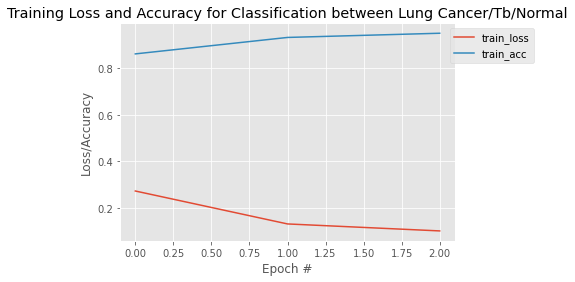

In [14]:
# plot the training loss and accuracy
#N = EPOCHS
N = 3
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), training.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), training.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), training.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), training.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy for Classification between Lung Cancer/Tb/Normal")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot.png")

In [15]:
print(tf._version_)

AttributeError: module 'tensorflow' has no attribute '_version_'

In [6]:
model.save_weights("model_vgg16_1.h5")

In [7]:
new_model = keras.models.load_model("model_vgg16_1.h5")

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001B5EFCBA4F0>.

In [8]:
model_new = tf.keras.models.load_model("model_vgg16_1.h5")

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001B5EF9550A0>.

In [10]:
reconstructed_model = keras.models.load_model("model_vgg16_1.h5")

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001B5836737F0>.